In [1]:

# !pip install gensim
# !pip install python-Levenshtein



import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords
from tqdm import tqdm
import re
import collections
# from wordcloud import STOPWORDS
# from scipy.sparse import csr_matrix
# from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
# import string
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from wordcloud import WordCloud
import gensim
import time
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import multiprocessing
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression



# Run the next cell only if you want to train the model. 
# If already trained, Skip to the next cell and directly load the model.

In [2]:
train_data = pd.read_csv("preprocessed_tokenized_training_data.csv")
train_data['concatenated_description'] = train_data['concatenated_description'].map(str)
train_data_idf = train_data.copy()

In [3]:
train_data

,Unnamed: 0,train_id,item_condition_id,price,shipping,concatenated_description
0,0,0,3,10.0,1,mlb cincinnati reds shirt size xl Not known de...
1,1,1,3,52.0,0,razer blackwidow chroma keyboard Razer keyboar...
2,2,2,1,10.0,1,avaviv blouse Target adorable top hint lace ke...
3,3,3,1,35.0,1,leather horse statues Not known new tags leath...
4,4,4,1,44.0,0,24k gold plated rose Not known complete certif...
...,...,...,...,...,...,...
1481656,1481656,1482530,2,20.0,1,free people inspired dress Free People lace sa...
1481657,1481657,1482531,2,14.0,0,little mermaid handmade dress Disney little me...
1481658,1481658,1482532,2,12.0,0,21 day fix containers eating plan Not known us...
1481659,1481659,1482533,3,45.0,1,world markets lanterns Not known 2 one see 2 r...


In [54]:
train_data['concatenated_description'] = train_data['concatenated_description'].apply(gensim.utils.simple_preprocess)

In [4]:
cores = multiprocessing.cpu_count()

# Build the Word2Vec model
# Continous bag of words
# Train the Word2Vec model

model2 = Word2Vec(vector_size=200, window=5, min_count=1, sg=0, workers=cores-1)
model2.build_vocab(train_data['concatenated_description'], progress_per=1000)
t = time.time()
model2.train(train_data['concatenated_description'], total_examples=model2.corpus_count, epochs=20)
print('Time to build vocab for Model-2: {} mins'.format(round((time.time() - t) / 60, 2)))


Time to build vocab for Model-2: 18.39 mins


In [5]:
model2.save("word2vec_cbow_model")

# One can directly load the model from here instead of training the models again.

In [ ]:
#Loading a pretrained model

model2 = Word2Vec.load("word2vec_cbow_model")


In [ ]:
def avg_word2vec2(doc):
    return np.mean([model2.wv[word] for word in doc if word in model2.wv.index_to_key], axis=0)

In [8]:
train_data_model2 = train_data.copy()

series = train_data_model2.concatenated_description.apply(avg_word2vec2)

df = pd.DataFrame(series.apply(pd.Series))

train_data_model2 = pd.concat([train_data_model2, df], axis=1)

train_data_model2 = train_data_model2.drop(['concatenated_description'],axis=1)

In [ ]:
train_data_model2.to_csv('avgword2vec_cbow.csv')

In [2]:
train_data_model2 = pd.read_csv('avgword2vec_cbow.csv')

In [3]:
train_data_model2.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'train_id', 'item_condition_id', 'price',
       'shipping', '0', '1', '2', '3',
       ...
       '190', '191', '192', '193', '194', '195', '196', '197', '198', '199'],
      dtype='object', length=206)

In [4]:
train_data_model2.drop(columns=['Unnamed: 0.1', 'Unnamed: 0', 'train_id'], inplace=True)

In [5]:
train_data_model2

,item_condition_id,price,shipping,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,2,8.0,1,-0.100559,-0.614330,0.208602,0.571966,-0.131203,0.016526,0.608419,...,-0.075749,0.193744,0.494159,-0.073508,0.494414,-0.169989,0.131777,0.145828,0.024475,-0.127633
1,3,14.0,0,-0.329170,-0.350506,0.272558,0.105843,1.208020,1.528792,-0.091454,...,-1.339325,0.835479,0.271060,0.437964,1.127263,1.099126,-0.569234,-0.982572,-0.126194,-0.116404
2,1,25.0,1,-0.240003,-0.041858,0.145329,0.452647,0.760089,0.097341,0.452785,...,0.418078,0.219362,0.174552,-0.024960,-0.002166,0.013162,-0.374551,-0.620355,0.631266,-0.212377
3,3,25.0,0,-0.101531,-0.345377,-0.117154,-0.361317,-0.764579,0.917608,0.777097,...,-0.010613,0.054686,0.057820,1.474908,0.728149,1.006546,-0.213868,0.185430,-0.457993,-0.727977
4,1,12.0,1,0.820777,-0.600387,-0.174789,-0.790316,0.611780,0.271854,0.250769,...,-0.093859,0.078621,-0.048399,-0.540433,0.852686,0.234550,-0.283534,-0.156189,0.549295,-0.314060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370407,1,20.0,1,0.484753,0.030433,-0.842793,-0.549632,0.861718,1.395888,1.131525,...,-0.391027,0.211749,-0.072331,1.241811,2.145595,1.513619,1.109203,-1.061759,0.059616,-1.878718
370408,1,44.0,0,-0.989117,-0.492069,-0.002195,0.631189,1.291212,-0.071031,0.779076,...,0.386589,0.272975,-0.883474,-0.305047,-1.207003,0.288548,-1.372537,-0.139790,1.139007,0.010722
370409,3,15.0,1,0.183705,0.060849,0.345536,0.088263,0.149190,0.014507,0.373666,...,-0.325529,0.767687,0.523542,0.516035,0.218952,0.475278,-0.767223,0.097173,-0.474679,-0.750847
370410,1,16.0,0,-0.263113,-0.582247,0.410359,-0.201431,0.439368,1.350481,0.880811,...,-0.339725,0.607348,-0.159939,0.906151,1.756508,0.985768,0.587361,-0.796640,-0.361518,-1.248246


In [6]:
train_data = pd.read_table('train.tsv')
train_data.shape

(1482535, 8)

## "avgword2vec_sg.csv" --> Will be used for "train_test_split", Contains 0.03 of entire dataset. 
## Generated from extracting dataset "preprocessed_tokenized_training_data.csv" and then applying "word2vec_cbow_model" on it.

# We've our dataset ready for the Model-2.

In [16]:
data = train_data_model2.copy()

In [17]:
data.shape

(370412, 203)

In [18]:
from sklearn.model_selection import train_test_split

y = data['price']
X = data.drop(columns=['price'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [19]:
X_train = X_train[:10000]
y_train = y_train[:10000]
X_test = X_test[:3500]
y_test = y_test[:3500]

# Kernelized Principal Component Analysis

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np


# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (R²) or Coefficient of Determination
r2 = r2_score(y_test, y_pred)
print("R-squared (R²):", r2)

# Explained Variance Score
explained_var = explained_variance_score(y_test, y_pred)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 902.9946614884985
Root Mean Squared Error (RMSE): 30.049869575232744
Mean Absolute Error (MAE): 17.334272752152053
R-squared (R²): 0.25722698287493817
Explained Variance Score: 0.2589359338598253


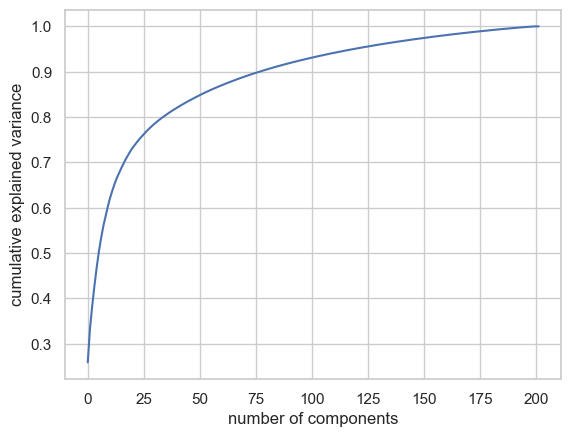

None

In [70]:
from sklearn.decomposition import KernelPCA
kpca_test = KernelPCA()
kpca_test = kpca_test.fit_transform(X_train)
explained_variance = np.var(kpca_test, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

sns.set(style='whitegrid')
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
display(plt.show())

evr = explained_variance_ratio
cvr = np.cumsum(explained_variance_ratio)

In [71]:
kpca_df = pd.DataFrame()
kpca_df['Cumulative Variance Ratio'] = cvr
kpca_df['Explained Variance Ratio'] = evr
display(kpca_df[kpca_df['Cumulative Variance Ratio'] >= 0.90])

,Cumulative Variance Ratio,Explained Variance Ratio
77,0.900771,0.001547
78,0.902298,0.001527
79,0.903815,0.001516
80,0.905303,0.001489
81,0.906774,0.001471
...,...,...
197,0.999257,0.000368
198,0.999592,0.000335
199,0.999922,0.000329
200,0.999971,0.000050


### From the above table, we can conclude that even if we use approx. half the number of components using Kernalized PCA, our new dataset will have a Cumulative Variance as 90% of the original dataset

# KPCA Tuned

In [20]:
from sklearn.decomposition import KernelPCA
kpca = KernelPCA(n_components=100)
X_K_train = kpca.fit_transform(X_train)
X_K_test = kpca.transform(X_test)

In [22]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

xgb = XGBRegressor()

xgb.fit(X_K_train, y_train)

# Make predictions on the test data
y_K_pred = xgb.predict(X_K_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_K_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 1387.4444593609317


In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np


# Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_K_pred)
print("Mean Squared Error (MSE):", mse)

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test,y_K_pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared (R²) or Coefficient of Determination
r2 = r2_score(y_test, y_K_pred)
print("R-squared (R²):", r2)

# Explained Variance Score
explained_var = explained_variance_score(y_test, y_K_pred)
print("Explained Variance Score:", explained_var)

Mean Squared Error (MSE): 1387.4444593609317
Root Mean Squared Error (RMSE): 37.24841552819303
Mean Absolute Error (MAE): 16.952696719574607
R-squared (R²): 0.053321491348978234
Explained Variance Score: 0.054197682454024454


In [24]:
from sklearn.model_selection import cross_val_score

# Create an MLPRegressor model with desired hyperparameters
model = xgb

# Define the input features X and the target variable y

# Perform cross-validation with 5 folds
num_folds = 5
scores = cross_val_score(model, X, y, cv=num_folds, scoring='neg_mean_squared_error')

# Cross-validation returns negative mean squared error, so we take the absolute values
mse_scores = -scores

# Compute the mean and standard deviation of the cross-validation scores
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()
# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_mse)
# Print the results
print("Mean MSE:", mean_mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Standard Deviation of MSE:", std_mse)

Mean MSE: 1038.2217317573202
Root Mean Squared Error (RMSE): 32.22144831874136
Standard Deviation of MSE: 51.88482959948403


In [25]:
import pickle
filename = 'model5.pkl'
with open(filename, 'wb') as file:
    pickle.dump(model, file)
